In [1]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from scipy.stats import chi2
from scipy.special import erfinv

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

import numpy as np

import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../../..')))
from tensiometer import utilities

def estimate_centroid_and_covariance(means, covariances):
    means = np.array(means)
    covariances = np.array(covariances)
    
    # Calculate the inverse of each covariance matrix
    inv_covariances = np.linalg.inv(covariances)
    
    # Calculate the weighted sum of the means
    weighted_means = np.einsum('ijk,ik->ij', inv_covariances, means)
    sum_inv_covariances = np.sum(inv_covariances, axis=0)
    
    # Calculate the centroid
    centroid = np.linalg.solve(sum_inv_covariances, np.sum(weighted_means, axis=0))
    
    # Calculate the covariance of the centroid
    centroid_covariance = np.linalg.inv(sum_inv_covariances)
    
    return centroid, centroid_covariance

2024-12-02 09:55:24.474619: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-02 09:55:24.547984: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-02 09:55:24.549298: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 09:55:26.022310: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Three moltivariate distributions

In [2]:
#Fixed Parameters
num_parameters = 2
num_datasets = 3

#Sharp triangle
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[0.01, 0.], [0., 0.01]])
cov_B = cov_A.copy()
cov_C = 100*cov_A.copy()

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)

names = ['x', 'y']
labels = ['x', 'y']

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')


# Anova-like stimators

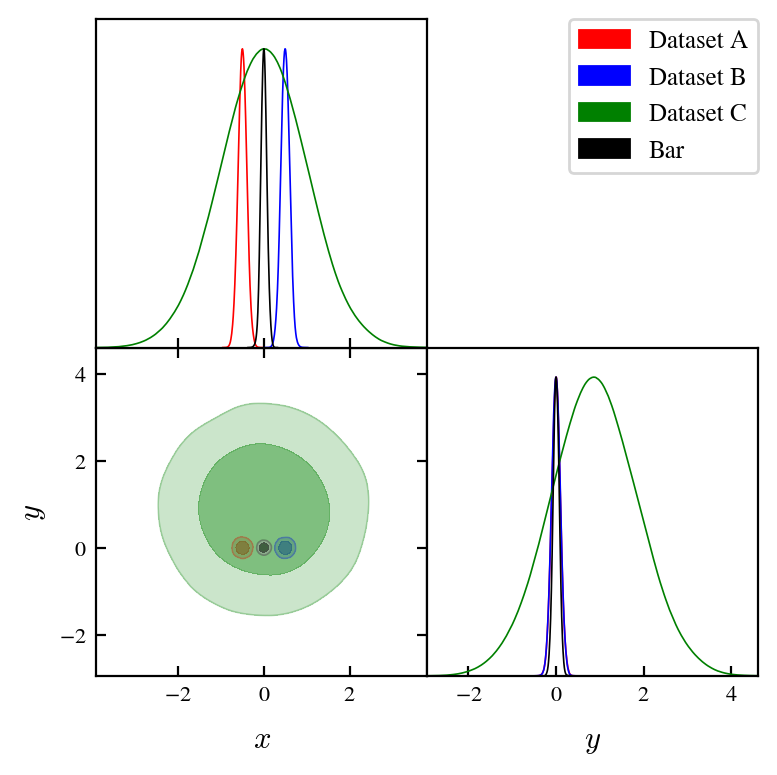

In [3]:
#mean_bar = (mean_A + mean_B + mean_C)/num_datasets

cov_tot = cov_A + cov_B + cov_C
#cov_bar = cov_tot / num_datasets**2

centroid, centroid_covariance = estimate_centroid_and_covariance([mean_A, mean_B, mean_C], [cov_A, cov_B, cov_C])
mean_bar = centroid
cov_bar = centroid_covariance


delta_theta_A = mean_A - mean_bar
delta_theta_B = mean_B - mean_bar
delta_theta_C = mean_C - mean_bar

samps_bar = np.random.multivariate_normal(mean_bar, cov_bar, size=10000)
chain_bar = MCSamples(samples=samps_bar, names=names, labels=labels, label='Bar')

colors = ['red', 'blue', 'green', 'black']

g = plots.get_subplot_plotter()
g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C, chain_bar],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors)
plt.savefig('triangle_plot_4_centroid.pdf')



## $\alpha$-stimator

\begin{equation}
    \alpha = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{\sum_{j} C_j}  (\theta_i - \bar{\theta})
\end{equation}

In [4]:
# Utility function to convert confidence level to sigma level
def from_confidence_to_sigma(confidence):
    return np.sqrt(2) * erfinv(confidence)

A_matrix = np.linalg.inv(cov_tot)

alpha = np.dot(delta_theta_A.T,np.dot(A_matrix, delta_theta_A)) \
      + np.dot(delta_theta_B.T,np.dot(A_matrix, delta_theta_B)) \
      + np.dot(delta_theta_C.T,np.dot(A_matrix, delta_theta_C))

print(r'alpha: {}'.format(alpha))


# Compute the eigenvalues of (\Sigma * A)
A_eigenval = np.linalg.eigvals(np.dot(cov_A+cov_bar, A_matrix))
B_eigenval = np.linalg.eigvals(np.dot(cov_B+cov_bar, A_matrix))
C_eigenval = np.linalg.eigvals(np.dot(cov_C+cov_bar, A_matrix))

coefficients = np.concatenate((A_eigenval, B_eigenval, C_eigenval))
num_samples = int(1e6)
print(coefficients)

# Generate samples from chi-squared distributions with 1 degree of freedom
samples = np.random.chisquare(df=1, size=(num_samples, len(coefficients)))
print(samples.shape)
print(samples)
# Compute the weighted sum for each sample
weighted_sums = np.dot(samples, coefficients)
# Estimate the P-value
PTE = np.mean(weighted_sums >= alpha)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:4g}'.format(n_sigma))


samp_chi2 = np.random.chisquare(df=1, size=num_samples) * (A_eigenval[0] + B_eigenval[0] + C_eigenval[0] + \
                                                        A_eigenval[1] + B_eigenval[1] + C_eigenval[1]) 

'''
samp_chi2 =(np.random.chisquare(df=1, size=num_samples) * A_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * A_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[1]
'''

PTE = samp_chi2[samp_chi2 > alpha].size/samp_chi2.size
print('PTE: {}'.format(PTE))
#n_sigma = from_confidence_to_sigma(1-PTE)
n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:4g}'.format(n_sigma))



alpha: 1.218228436395721
[0.01468149 0.01468149 0.01468149 0.01468149 0.98526973 0.98526973]
(1000000, 6)
[[0.10659384 0.15542937 0.50802884 0.13711825 2.74460541 0.10982605]
 [0.63450276 3.86703432 4.22136253 0.08418201 0.01631767 0.30495156]
 [0.12282314 0.14526839 0.05508469 0.02277635 0.03332881 0.21515265]
 ...
 [1.46208003 5.5104936  2.92482703 0.40421135 0.75338996 0.7470147 ]
 [0.40469583 0.39249419 0.07749292 1.02293719 0.32055513 0.101002  ]
 [0.87763205 0.24761757 1.95643158 1.79702519 1.75716365 0.48457802]]
PTE: 0.555395
n_sigma: 0.589695
PTE: 0.439159
n_sigma: 0.773614


## $\beta$-stimator

\begin{equation}
    \beta = \sum_{i,j} (\theta_i - \theta_j)^{T}  \frac{1}{C_{i}+C_{j}}  (\theta_i - \theta_j)
\end{equation}

In [5]:
beta = np.dot((mean_A - mean_B).T, np.dot(np.linalg.inv(cov_A + cov_B), (mean_A - mean_B))) \
     + np.dot((mean_A - mean_C).T, np.dot(np.linalg.inv(cov_A + cov_C), (mean_A - mean_C))) \
     + np.dot((mean_B - mean_C).T, np.dot(np.linalg.inv(cov_B + cov_C), (mean_B - mean_C)))


print(r'beta: {}'.format(beta))

df=num_datasets*num_parameters
PTE = chi2.sf(beta, df)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

samp_chi2 = np.random.chisquare(df=num_datasets*num_parameters, size=int(1e8))
PTE = samp_chi2[samp_chi2 > beta].size/samp_chi2.size
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

beta: 51.980198019801975
PTE: 1.8819936078083364e-09
n_sigma: 6.00768
PTE: 0.0
n_sigma:   inf


## $\gamma$-stimator

\begin{equation}
    \gamma = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{C_{i}}  (\theta_i - \bar{\theta})
\end{equation}

In [6]:
gamma = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A), delta_theta_A)) \
      + np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B), delta_theta_B)) \
      + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C), delta_theta_C))

print(r'gamma: {}'.format(gamma))

# Compute the eigenvalues of (\Sigma * A)
A_eigenval = np.linalg.eigvals(np.dot(cov_A+cov_bar, A_matrix))
B_eigenval = np.linalg.eigvals(np.dot(cov_B+cov_bar, A_matrix))
C_eigenval = np.linalg.eigvals(np.dot(cov_C+cov_bar, A_matrix))

coefficients = np.concatenate((A_eigenval, B_eigenval, C_eigenval))
num_samples = int(1e6)
print(coefficients)

# Generate samples from chi-squared distributions with 1 degree of freedom
samples = np.random.chisquare(df=1, size=(num_samples, len(coefficients)))
print(samples.shape)
print(samples)
# Compute the weighted sum for each sample
weighted_sums = np.dot(samples, coefficients)
# Estimate the P-value
PTE = np.mean(weighted_sums >= gamma)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))



samp_chi2 = np.random.chisquare(df=1, size=num_samples) * (A_eigenval[0] + B_eigenval[0] + C_eigenval[0] + \
                                                           A_eigenval[1] + B_eigenval[1] + C_eigenval[1]) 

'''
samp_chi2 =(np.random.chisquare(df=1, size=num_samples) * A_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * A_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[1]
'''

PTE = samp_chi2[samp_chi2 >= gamma].size/samp_chi2.size
print('PTE: {}'.format(PTE))
#n_sigma = from_confidence_to_sigma(1-PTE)
n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

gamma: 50.74626865671642
[0.01468149 0.01468149 0.01468149 0.01468149 0.98526973 0.98526973]
(1000000, 6)
[[1.01477088e+00 9.79699626e-01 2.57275810e+00 5.09783691e-01
  2.01880590e-01 1.33401657e-02]
 [3.10101712e-01 2.44821314e-01 5.10572526e-02 4.47801912e-01
  1.47467737e+00 9.41934700e-01]
 [3.79722126e-01 2.08685243e+00 5.13304012e-03 5.02037434e-02
  1.33555094e+00 6.59685178e+00]
 ...
 [4.45883005e+00 5.32037607e-01 7.94561407e-01 3.58299354e-01
  3.29626294e-02 6.01311561e-03]
 [3.60735563e+00 1.61543123e+00 2.19277333e+00 1.30889469e-01
  2.85257440e+00 1.00179828e-01]
 [3.68612131e-01 2.49116090e+00 1.34519903e-01 5.68622778e-03
  9.79926966e-01 1.77239766e+00]]
PTE: 0.0
n_sigma:   inf
PTE: 1e-06
n_sigma: 4.89164


## $\delta$-stimator

\begin{equation}
    \delta = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{\bar{C}}  (\theta_i - \bar{\theta}) = n^{2} \cdot \alpha
\end{equation}

In [7]:
A_matrix = np.linalg.inv(cov_bar)

delta = np.dot(delta_theta_A.T,np.dot(A_matrix, delta_theta_A)) \
      + np.dot(delta_theta_B.T,np.dot(A_matrix, delta_theta_B)) \
      + np.dot(delta_theta_C.T,np.dot(A_matrix, delta_theta_C))

# Compute the eigenvalues of (\Sigma * A)
A_eigenval = np.linalg.eigvals(np.dot(cov_A+cov_bar, A_matrix))
B_eigenval = np.linalg.eigvals(np.dot(cov_B+cov_bar, A_matrix))
C_eigenval = np.linalg.eigvals(np.dot(cov_C+cov_bar, A_matrix))

coefficients = np.concatenate((A_eigenval, B_eigenval, C_eigenval))
num_samples = int(1e6)
print(coefficients)

# Generate samples from chi-squared distributions with 1 degree of freedom
samples = np.random.chisquare(df=1, size=(num_samples, len(coefficients)))
print(samples.shape)
print(samples)
# Compute the weighted sum for each sample
weighted_sums = np.dot(samples, coefficients)
# Estimate the P-value
PTE = np.mean(weighted_sums >= delta)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))


samp_chi2 = np.random.chisquare(df=1, size=num_samples) * (A_eigenval[0] + B_eigenval[0] + C_eigenval[0] + \
                                                           A_eigenval[1] + B_eigenval[1] + C_eigenval[1]) 

'''
samp_chi2 =(np.random.chisquare(df=1, size=num_samples) * A_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[0] +\
            np.random.chisquare(df=1, size=num_samples) * A_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * B_eigenval[1] +\
            np.random.chisquare(df=1, size=num_samples) * C_eigenval[1]
'''



PTE = samp_chi2[samp_chi2 > delta].size/samp_chi2.size
print('PTE: {}'.format(PTE))
#n_sigma = from_confidence_to_sigma(1-PTE)
n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))



[  3.01   3.01   3.01   3.01 202.   202.  ]
(1000000, 6)
[[1.00895739e-04 7.83097396e-02 1.22735401e+00 4.43900055e-01
  9.19237223e-01 4.10082602e-01]
 [1.48135197e+00 1.70231548e-01 2.79638397e-01 4.36440578e-01
  3.71657023e-01 7.22865621e-01]
 [2.55333385e-02 3.20187444e+00 2.68569346e+00 3.84790709e-01
  4.75517905e-01 1.07578834e-01]
 ...
 [1.39248717e-01 1.25698179e+00 6.32122797e-01 7.72601289e-01
  1.72379426e+00 5.64367736e-04]
 [8.55844189e-01 5.12062650e-01 4.12566083e-01 1.36939760e+00
  1.78108793e-01 1.04362545e+00]
 [2.87921952e+00 3.78835404e-02 1.05847071e+00 4.81500403e-01
  1.07033986e-01 6.13538882e-01]]
PTE: 0.554854
n_sigma: 0.590502
PTE: 0.438147
n_sigma: 0.775326


## $\epsilon$-stimator

\begin{equation}
    \epsilon = \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{C_i + \bar{C}}  (\theta_i - \bar{\theta})
\end{equation}

In [8]:
epsilon = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A + cov_bar), delta_theta_A)) \
        + np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B + cov_bar), delta_theta_B)) \
        + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C + cov_bar), delta_theta_C))
print(r'epsilon: {}'.format(epsilon))

df=num_datasets*num_parameters
PTE = chi2.sf(epsilon, df)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

samp_chi2 = np.random.chisquare(df=num_datasets*num_parameters, size=int(1e8))
PTE = samp_chi2[samp_chi2 > epsilon].size/samp_chi2.size
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

epsilon: 34.130063474934786
PTE: 6.3493181930100735e-06
n_sigma: 4.51441
PTE: 6.43e-06
n_sigma: 4.51173


## $\zeta$-stimator

\begin{equation}
    \zeta = \sum_{i,j} (\theta_i - \theta_j)^{T}  \frac{1}{C_{i}+C_{j}}  (\theta_i - \theta_j) + \sum_{i} (\theta_i - \bar{\theta})^{T}  \frac{1}{C_i + \bar{C}}  (\theta_i - \bar{\theta})
\end{equation}

In [9]:
epsilon = np.dot(delta_theta_A.T,np.dot(np.linalg.inv(cov_A + cov_bar), delta_theta_A)) \
        + np.dot(delta_theta_B.T,np.dot(np.linalg.inv(cov_B + cov_bar), delta_theta_B)) \
        + np.dot(delta_theta_C.T,np.dot(np.linalg.inv(cov_C + cov_bar), delta_theta_C))

beta = np.dot((mean_A - mean_B).T, np.dot(np.linalg.inv(cov_A + cov_B), (mean_A - mean_B))) \
     + np.dot((mean_A - mean_C).T, np.dot(np.linalg.inv(cov_A + cov_C), (mean_A - mean_C))) \
     + np.dot((mean_B - mean_C).T, np.dot(np.linalg.inv(cov_B + cov_C), (mean_B - mean_C)))


zeta = beta + epsilon

print(r'beta: {}'.format(beta))
print(r'epsilon: {}'.format(epsilon))
print(r'zeta: {}'.format(zeta))

df=2*num_datasets*num_parameters
PTE = chi2.sf(zeta, df)
print('PTE: {}'.format(PTE))

n_sigma = utilities.from_confidence_to_sigma(1-PTE)
print('n_sigma: {:5g}'.format(n_sigma))

beta: 51.980198019801975
epsilon: 34.130063474934786
zeta: 86.11026149473676
PTE: 2.7831316632916184e-13
n_sigma: 7.30448
